In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect = True)

# reflect the tables
inspector = inspect(engine)
my_list = inspector.get_table_names()

In [7]:
# We can view all of the classes that automap found
print('Printing columns for found tables')
print ('-' * 12)
for table in my_list:
    print(f'Retrieving for table: {table}')
    columns = inspector.get_columns(table)
    for column in columns:
        print(column['name'], column['type'])
    print('-' * 12)
    


Printing columns for found tables
------------
Retrieving for table: measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
------------
Retrieving for table: station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
------------


In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Fetching precipitation data from 2016-08-23 to 2017-08-23
------------
Fetch succesful! Saving into DataFrame...
Query succesfully saved into prcp_df DataFrame.


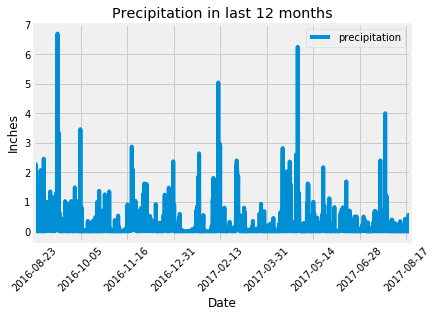

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
end_date_query = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
for date in end_date_query:
    date_str = date

year = int(date_str[:4])
day = int(date_str[-2:])
month = int(date_str[5:7])
end_date = dt.date(year, month, day)
start_date = end_date - dt.timedelta(days = 365)

print(f'Fetching precipitation data from {start_date} to {end_date}')
print('-' * 12)

# Perform a query to retrieve the data and precipitation scores
prcp_results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    order_by(Measurement.date).all()
print('Fetch succesful! Saving into DataFrame...')

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_results).\
    set_index('date').\
    rename(columns = {'prcp': 'precipitation'}).\
    dropna()

print('Query succesfully saved into prcp_df DataFrame.')

# Use Pandas Plotting with Matplotlib to plot the data
plot = prcp_df.plot()
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation in last 12 months')
plt.xticks(rotation = 45)
display(plot)


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000

In [12]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).group_by(Measurement.station).count()
print(f'Available stations: {stations}')

Available stations: 9


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_ordered = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).\
    all()

stations_list = []
measurements_list = []
for station, measurement in stations_ordered:
    stations_list.append(station)
    measurements_list.append(measurement)

stations_ordered_df = pd.DataFrame({'Station': stations_list, 'Measurement count': measurements_list})
display(stations_ordered_df)

Station  Measurement count
0  USC00519281               2772
1  USC00519397               2724
2  USC00513117               2709
3  USC00519523               2669
4  USC00516128               2612
5  USC00514830               2202
6  USC00511918               1979
7  USC00517948               1372
8  USC00518838                511

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = stations_list[0]
temp_summary = session.query(func.min(Measurement.tobs),
             func.max(Measurement.tobs),
             func.avg(Measurement.tobs)).\
            filter(Measurement.station == most_active_station)

for record in temp_summary:
    min_temp, max_temp, avg_temp = record
    
print(f'Printing record for most active station\nStation id: {most_active_station}\nMin. Temp (°F): {min_temp}\nMax. Temp (°F): {max_temp}\nAvg. Temp (°F): {round(avg_temp, 1)}')


Printing record for most active station
Station id: USC00519281
Min. Temp (°F): 54.0
Max. Temp (°F): 85.0
Avg. Temp (°F): 71.7


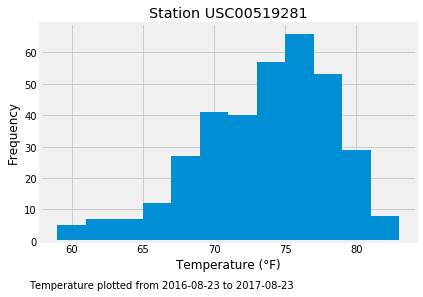

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_results = session.query(Measurement.tobs).\
                filter(Measurement.station == most_active_station).\
                filter(Measurement.date >= start_date).\
                filter(Measurement.date <= end_date)

temp_results_df = pd.DataFrame(temp_results).rename(columns = {'tobs': 'Temperature'})
plot = temp_results_df.plot(kind = 'hist', bins = 12, legend = False)
plt.title(f'Station {most_active_station}')
plt.xlabel('Temperature (°F)')
plt.text(57,-15,f'Temperature plotted from {start_date} to {end_date}')
display(plot)

## Bonus Challenge Assignment

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [23]:
# Plot the daily normals as an area plot with `stacked=False`
